In [67]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
import seaborn as sns
import datetime
import matlab.engine

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']

model_size = 107  # nodes

# Horizon for each problem
ndays = 'full'
n_int_steps = 1

setup = ItalySetup(model_size, ndays)
M = setup.nnodes
N = len(setup.model_days) - 1


Loaded Italy Setup with 107 nodes.


In [68]:
eng = matlab.engine.start_matlab()
eng.cd('geography-paper-master/', nargout=0)
eng.run('single_build.m', nargout=0)
integ_matlab = np.array(eng.eval('x'))

matlab_start_date = datetime.date(2020, 1, 20)  # fix lentgh
matlab_end_date = datetime.date(2020, 7, 1)
matlab_model_days = pd.date_range(matlab_start_date, matlab_end_date, freq='1D')

In [69]:
mydata = pd.read_csv('df_integ_0.csv', index_col= 'date', parse_dates=True, )
mydata.head()

,comp,place,value,placeID
date,,,,
2020-01-20,vacc,Torino,0.0,0
2020-01-21,vacc,Torino,0.0,0
2020-01-22,vacc,Torino,0.0,0
2020-01-23,vacc,Torino,0.0,0
2020-01-24,vacc,Torino,0.0,0


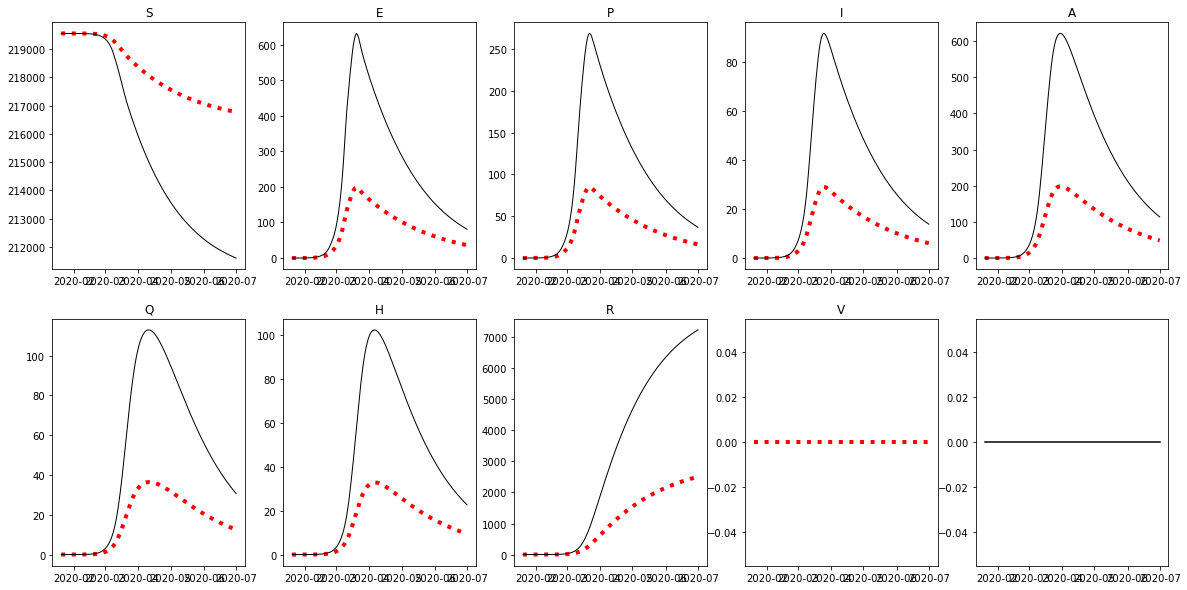

In [70]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,5, figsize = (20,10))
fig.patch.set_facecolor('white')

nd = 10

for i, st in enumerate(states_names):
    axes.flat[i].plot(mydata[(mydata['comp'] == st) & (mydata['placeID'] == nd)]['value'], linestyle=':', lw = 4, color='r')
    if st != 'V':
        axes.flat[i].plot(matlab_model_days, np.array(integ_matlab.T[nd+107*i,:].T), linestyle='-', lw = 1, color='k')

    axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc') & (mydata['placeID'] == nd)]['value'], 'k',label=r"$\nu(t)$");